In [1]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [60]:
import math
from graphviz import Digraph

In [31]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [106]:
def dfs(startingNode):
    visited = set()
    result = []

    def visit(node):
        if node not in visited:
            visited.add(node)
            for child in node._prev:
                visit(child)
            result.append(node)
    
    visit(startingNode)
    return result

In [107]:
class Value:
    def __init__(self, value, label = '', _children=(), _op=''):
        self.grad = 0
        self.data = value
        self.label = label
        
        self._op = _op
        self._prev = set(_children)
        self._backward = lambda : None
    
    def backward(self):
        for node in reversed(dfs(self)):
            node._backward()

    def tanh(self):
        out = Value(math.tanh(self.data), _children = (self, ), _op='tanh')

        def _backward():
            self.grad += (1 - out.data ** 2) * out.grad

        out._backward = _backward

        return out

    def __repr__(self):
        return f"Value({self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children = (self, other), _op = '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children = (self, other), _op = '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    

    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self + other


In [108]:
v1 = Value(1.0, 'v1')
v2 = Value(-2.0, 'v2')
v3 = Value(3.0, 'v3')

v4 = v1 + v2
v4.label = 'v4'

v5 = v4 * v3
v5.label = 'v5'

v6 = v5.tanh()
v6.label = 'v6'

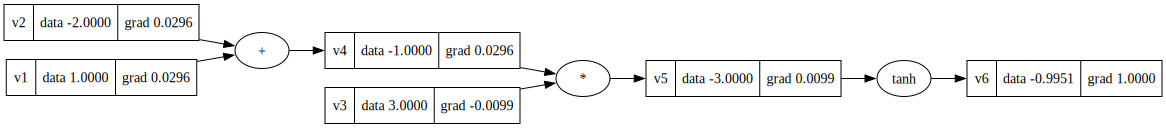

In [115]:
draw_dot(v6)

In [114]:
v6.grad = 1.0
v6.backward()